In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
import numpy as np
import os
import tensorflow
from keras.layers import Dense, Input
from keras import Model, regularizers
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [67]:
import csv
import pandas as pd

SEED = 7

In [100]:
# extracting DF
file_dir = '/Users/ori/pergit/JavaTracer/JavaTracerUtils/data/lang/1/method_traces/'
file_path = file_dir + 'a5487ff1ad96[buggy].csv'
df = pd.read_csv(file_path)
vector = str(df.iloc[0]['vector']).split(',')
should_remove_first_feature = False
feature_names = ['f' + str(idx) for idx in range(1, len(vector)+1)]
df[feature_names] = df['vector'].str.split(',', expand=True)
fs_and_goal = feature_names + ['is_faulty']
if vector[0] == 'S':
    fs_and_goal = fs_and_goal[1:]  # removing first feature (static symbol)
df = df[fs_and_goal]
df = df.replace("NULL", -7)
df = df.apply(pd.to_numeric, errors='raise')
print(df)

            f2          f3  is_faulty
0    289748645  1891459540          0
1    560062239   167533639          0
2    386809456    50761472          0
3    289748645  1891459540          0
4    560062239   545226072          0
5    301870355  1827302553          0
6    310372524  2142127142          0
7    167533639   590775724          0
8   1350693187  1610121531          0
9    871135670  1781184091          0
10   438978257  2080315477          0
11   680965132   571014259          0
12  2079716217   321377696          0
13   473564467   623601087          0
14  1143271849  1433776434          0
15   566523251  1761272406          0
16   790737394  1294573322          0
17  1736995097   783897961          0
18   966257654  2091835767          0
19  1028950932  1509959005          0
20  1066740436  1808718578          0
21  1502117161   884964266          0
22          -7          -7          0
23   290727660   748265909          0
24  1315968767  1106573842          0
25   9781794

In [101]:
faulty_mask = df['is_faulty'] == 1
faulty_probes = df[faulty_mask]
non_faulty_probes = df[~faulty_mask]
print(non_faulty_probes.shape)

(69, 3)


In [102]:
X_train, X_test = train_test_split(non_faulty_probes, test_size=0.1, random_state=SEED)
X_train = X_train.drop(['is_faulty'], axis=1)

X_test = pd.concat([X_test, faulty_probes])
y_test = X_test['is_faulty']
X_test = X_test.drop(['is_faulty'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape
X_train

array([[1143271849, 1433776434],
       [ 790737394, 1294573322],
       [1736995097,  783897961],
       [1433776434,  566523251],
       [ 566523251, 1761272406],
       [ 473564467,  623601087],
       [ 660075871,  167533639],
       [2025545037, 2043003902],
       [1913025892, 1242943767],
       [1502117161,  884964266],
       [ 321377696,  473564467],
       [1066740436, 1808718578],
       [1736995097,  473564467],
       [ 938317140,  370272693],
       [ 566523251, 1761272406],
       [2079716217, 1346620547],
       [ 438978257, 2080315477],
       [1040618661,  571014259],
       [1610121531,  871135670],
       [2079716217,  321377696],
       [        -7,         -7],
       [1460048766,  660075871],
       [ 783897961,  160856182],
       [ 560062239,  167533639],
       [ 790737394, 1294573322],
       [ 310372524, 1827302553],
       [        -7,         -7],
       [ 289748645, 1891459540],
       [2080315477,  680965132],
       [ 487850097, 1560282618],
       [17

In [142]:

input_dim = X_train.shape[1]
encoding_dim = 1

input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="relu")(encoder)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(1, activation="relu")(encoder)
decoder = Dense(1, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [143]:
nb_epoch = 20
batch_size = 10
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[tensorboard]).history

Train on 62 samples, validate on 12 samples


Epoch 1/20


10/62 [===>..........................] - ETA: 1s - loss: 1536992735939002368.0000 - acc: 0.4000

62/62 [==============================] - 0s 7ms/step - loss: 1397663092419778304.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 2/20
10/62 [===>..........................] - ETA: 0s - loss: 1489876463665545216.0000 - acc: 0.3000

62/62 [==============================] - 0s 325us/step - loss: 1397663087986263552.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 3/20
10/62 [===>..........................] - ETA: 0s - loss: 1329963080204943360.0000 - acc: 0.5000

62/62 [==============================] - 0s 343us/step - loss: 1397663038109223936.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 4/20
10/62 [===>..........................] - ETA: 0s - loss: 1507204217163481088.0000 - acc: 0.6000

62/62 [==============================] - 0s 306us/step - loss: 1397663107937079552.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 5/20
10/62 [===>..........................] - ETA: 0s - loss: 1163721732448583680.0000 - acc: 0.5000

62/62 [==============================] - 0s 302us/step - loss: 1397663074685719808.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 6/20
10/62 [===>..........................] - ETA: 0s - loss: 2002401714325422080.0000 - acc: 0.3000

62/62 [==============================] - 0s 368us/step - loss: 1397663114587351296.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 7/20
10/62 [===>..........................] - ETA: 0s - loss: 1778957861817155584.0000 - acc: 0.6000

62/62 [==============================] - 0s 350us/step - loss: 1397663063601933056.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 8/20
10/62 [===>..........................] - ETA: 0s - loss: 1097162933500116992.0000 - acc: 0.3000

62/62 [==============================] - 0s 334us/step - loss: 1397663150055468288.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 9/20
10/62 [===>..........................] - ETA: 0s - loss: 1731404258793750528.0000 - acc: 0.4000

62/62 [==============================] - 0s 295us/step - loss: 1397663072468962304.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 10/20
10/62 [===>..........................] - ETA: 0s - loss: 1291418463142674432.0000 - acc: 0.6000

62/62 [==============================] - 0s 361us/step - loss: 1397663143405196544.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 11/20
10/62 [===>..........................] - ETA: 0s - loss: 1909168900726063104.0000 - acc: 0.5000

62/62 [==============================] - 0s 445us/step - loss: 1397663090203020800.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 12/20
10/62 [===>..........................] - ETA: 0s - loss: 723947043030040576.0000 - acc: 0.5000

62/62 [==============================] - 0s 370us/step - loss: 1397663125671138048.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 13/20
10/62 [===>..........................] - ETA: 0s - loss: 1057861714998984704.0000 - acc: 0.4000

62/62 [==============================] - 0s 372us/step - loss: 1397663101286807552.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 14/20


10/62 [===>..........................] - ETA: 0s - loss: 1273715226423853056.0000 - acc: 0.5000

62/62 [==============================] - 0s 719us/step - loss: 1397663121237623296.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 15/20


10/62 [===>..........................] - ETA: 0s - loss: 976903299456303104.0000 - acc: 0.6000

62/62 [==============================] - 0s 571us/step - loss: 1397663065818690560.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 16/20


10/62 [===>..........................] - ETA: 0s - loss: 1687166095644950528.0000 - acc: 0.4000

62/62 [==============================] - 0s 569us/step - loss: 1397663123454380544.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 17/20
10/62 [===>..........................] - ETA: 0s - loss: 1534776257936359424.0000 - acc: 0.4000

62/62 [==============================] - 0s 391us/step - loss: 1397663043651117312.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 18/20


10/62 [===>..........................] - ETA: 0s - loss: 1482951739433811968.0000 - acc: 0.3000

62/62 [==============================] - 0s 300us/step - loss: 1397663132321409792.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 19/20


10/62 [===>..........................] - ETA: 0s - loss: 942960069836800000.0000 - acc: 0.6000

62/62 [==============================] - 0s 401us/step - loss: 1397663114587351296.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


Epoch 20/20
10/62 [===>..........................] - ETA: 0s - loss: 1282796505274515456.0000 - acc: 0.3000

62/62 [==============================] - 0s 296us/step - loss: 1397663081335991552.0000 - acc: 0.4839 - val_loss: 1436857371592403712.0000 - val_acc: 0.4167


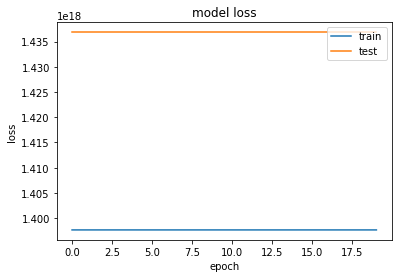

In [139]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [129]:
predictions = autoencoder.predict(X_test)
print(y_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

18    0
2     0
58    0
27    0
50    0
37    0
38    0
31    1
32    1
33    1
34    1
35    1
Name: is_faulty, dtype: int64


,reconstruction_error,true_class
count,1.200000e+01,12.000000
mean,1.436857e+18,0.416667
std,1.203314e+18,0.514929
min,4.888832e+16,0.000000
25%,2.730520e+17,0.000000
50%,1.138565e+18,0.000000
75%,2.554559e+18,1.000000
max,3.155207e+18,1.000000


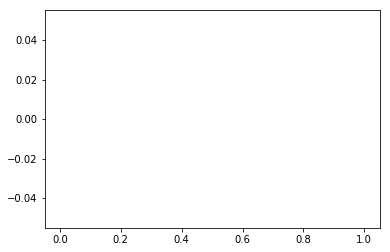

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class'] == 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

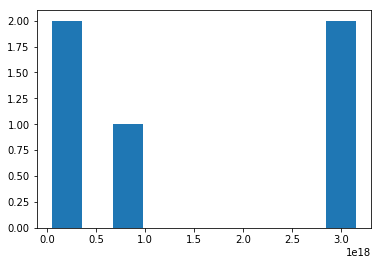

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

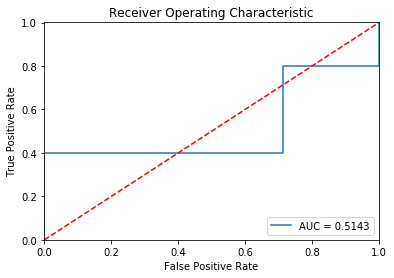

In [135]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();